This notebook is to cluster the various diseases together that are the same disease, or indication for taking a drug but written different ways. Rename disease after filtering by medicine so it is more accurate?

In [ ]:
import pandas as pd
import numpy as np

import os
from tqdm import tqdm
!pip install scispacy
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.4/en_ner_bc5cdr_md-0.5.4.tar.gz
!pip install spacy
import en_ner_bc5cdr_md
!python3 -m spacy download en_core_web_sm
import spacy
import re
!pip install sentence-transformers
!pip install scikit-learn
!pip install hdbscan
from sklearn.cluster import DBSCAN
import hdbscan 
!pip install transformers torch


In [ ]:
# path_reactions = '/content/drive/My Drive/CSV/reactions.csv'
# path_reports = '/content/drive/My Drive/CSV/reports.csv'
path_drugs = '/Users/jada/Desktop/Project/unbIAsed.Rx/Notebooks/CSVFiles/drugs.csv'

# df_reactions = pd.read_csv(path_reactions)
# df_reports = pd.read_csv(path_reports)
df_drugs = pd.read_csv(path_drugs)
pd.set_option('display.width', 500)
print(df_drugs.head())

In [ ]:
df_drugs['INDICATION_NAME_ENG'] = df_drugs['INDICATION_NAME_ENG'].str.upper()
unique_diseases = df_drugs['INDICATION_NAME_ENG'].unique()
print(len(unique_diseases))

disease_df = pd.DataFrame(unique_diseases, columns=['INDICATION_NAME_ENG'])
print(disease_df.head(20))

save_directory = '/Users/jada/Desktop/Project/unbIAsed.Rx/Notebooks/CSVFiles'
disease_df.to_csv(os.path.join(save_directory, 'diseases.csv'), index=False)

In [ ]:
# load the diseases
diseases_path = '/Users/jada/Desktop/Project/unbIAsed.Rx/Notebooks/CSVFiles/diseases.csv'
diseases_df = pd.read_csv(diseases_path)

In [ ]:
# testing the NER model

nlp = spacy.load('en_ner_bc5cdr_md')
def get_disease_group(indication):
    doc = nlp(indication)
    for ent in doc.ents:
        if ent.label_ == "DISEASE":
            return ent.text
    return indication 

disease = get_disease_group('RECTAL CANCER STAGE IV')
print(disease)

In [ ]:
# data = {
#     'INDICATION_NAME_ENG': [
#         "Diabetes Mellitus", "High blood pressure", "Type 2 DM", 
#         "Hypertension", "Diabetic ketoacidosis", "Type 1 diabetes", 
#         "Hypertensive crisis", "DM type 2"
#     ]
# }
# diseases_df = pd.DataFrame(data)

In [99]:
path_diseases_drugs = '/Users/jada/Desktop/Project/unbIAsed.Rx/Notebooks/CSVFiles/drugs_alternates.csv'
diseases_drug_df = pd.read_csv(path_diseases_drugs)
diltiazem_df = diseases_drug_df[diseases_drug_df['ALTERNATE DRUG'] == 'DILTIAZEM']
diltiazem_df['INDICATION_NAME_ENG'] = diltiazem_df['INDICATION_NAME_ENG'].str.upper()
print(diltiazem_df)
diltiazem_diseases = diltiazem_df['INDICATION_NAME_ENG'].unique()
print(diltiazem_diseases)
print(len(diltiazem_diseases))


         REPORT_ID                        DRUGNAME                  INDICATION_NAME_ENG ALTERNATE DRUG
86          309765                        DILTAZEM                           ARRHYTHMIA      DILTIAZEM
1221        360100                       DILTIAZEM           BLOOD PRESSURE MEASUREMENT      DILTIAZEM
4616        435114                          TIAZAC  PRODUCT USED FOR UNKNOWN INDICATION      DILTIAZEM
6950     900570185                        CARDIZEM  PRODUCT USED FOR UNKNOWN INDICATION      DILTIAZEM
7209        679082                       DILTIAZEM                         HYPERTENSION      DILTIAZEM
...            ...                             ...                                  ...            ...
2984475  906818078                       DILTIAZEM  PRODUCT USED FOR UNKNOWN INDICATION      DILTIAZEM
2984496  906818078  TIAZAC DILTIAZEM HYDROCHLORIDE  PRODUCT USED FOR UNKNOWN INDICATION      DILTIAZEM
2984674  906549930                       DILTIAZEM                       

/var/folders/sg/pjszdfvx5rxfvg2gwg3zj2f80000gn/T/ipykernel_84468/2207046135.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diltiazem_df['INDICATION_NAME_ENG'] = diltiazem_df['INDICATION_NAME_ENG'].str.upper()


In [100]:
# Preprocessing
nlp = spacy.load('en_core_web_sm')

def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc if not token.is_stop])

tqdm.pandas()
# preprocessed = diseases_df['INDICATION_NAME_ENG'].progress_apply(preprocess).tolist()
preprocessed = map(lambda x: preprocess(x), diltiazem_diseases)
preprocessed = list(preprocessed)

In [101]:
# vectorize the data
from sentence_transformers import SentenceTransformer
from tqdm.autonotebook import tqdm, trange

# model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
# model = SentenceTransformer('all-MiniLM-L6-v2')
model = SentenceTransformer('paraphrase-MiniLM-L12-v2')
# model = SentenceTransformer('all-mpnet-base-v2')
# model = SentenceTransformer('sentence-transformers/stsb-roberta-base')
# model = SentenceTransformer('pritamdeka/S-Biomed-Roberta-snli-multinli-stsb')
# model = SentenceTransformer('pritamdeka/S-PubMedBert-MS-MARCO')

embeddings = model.encode(preprocessed, show_progress_bar=True)

Batches: 100%|██████████| 3/3 [00:01<00:00,  2.41it/s]


In [ ]:
# vectorization

from transformers import AutoModel, AutoTokenizer
import torch

# modelName = 'dmis-lab/biobert-base-cased-v1.1'
modelName = 'allenai/scibert_scivocab_uncased'
tokenizer = AutoTokenizer.from_pretrained(modelName)
model = AutoModel.from_pretrained(modelName)

def getEmbeddings(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state
    sentence_embedding = embeddings.mean(dim=1).squeeze().numpy()
    return sentence_embedding


embeddings = [getEmbeddings(text) for text in tqdm(preprocessed)]


In [102]:
# clustering

dbscan = DBSCAN(eps=0.5, min_samples=2, metric='cosine')

clusterer = hdbscan.HDBSCAN(
    metric='euclidean', 
    min_cluster_size=2,  # Adjust based on dataset size and desired granularity
    min_samples=1,  # Adjust based on noise level
    cluster_selection_method='leaf' # or try 'leaf')
    )  

clusters = clusterer.fit_predict(embeddings)

clustered_indications = {}
for i, label in enumerate(clusters):
    if label not in clustered_indications:
        clustered_indications[label] = []
    # clustered_indications[label].append(diseases_df['INDICATION_NAME_ENG'][i]) # change as needed
        clustered_indications[label].append(diltiazem_diseases[i])

# Print clustered indications
for cluster, descriptions in clustered_indications.items():
    print(f"Cluster {cluster}:")
    for description in descriptions:
        print(f"  - {description}")

print(len(clustered_indications))
print(len(clustered_indications.get(-1)))

Cluster 10:
  - ARRHYTHMIA
Cluster 8:
  - BLOOD PRESSURE MEASUREMENT
Cluster -1:
  - PRODUCT USED FOR UNKNOWN INDICATION
Cluster 4:
  - HYPERTENSION
Cluster 12:
  - CARDIAC DISORDER
Cluster 6:
  - CORONARY ARTERY DISEASE
Cluster 3:
  - ANGINA PECTORIS
Cluster 11:
  - SUPRAVENTRICULAR TACHYCARDIA
Cluster 7:
  - BLOOD PRESSURE INCREASED
Cluster 0:
  - INTENTIONAL OVERDOSE
Cluster 9:
  - MYOCARDIAL INFARCTION
Cluster 5:
  - HEART RATE INCREASED
Cluster 2:
  - DYSLIPIDAEMIA
Cluster 13:
  - CARDIAC FAILURE
Cluster 1:
  - INNER EAR DISORDER
15
1


In [104]:
!pip install umap

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Preparing metadata (setup.py) ... done
  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3542 sha256=f8ba94fdad8730949df524319ef9340e09828c3f4cf82c1929c4defe7023813f
  Stored in directory: /Users/jada/Library/Caches/pip/wheels/15/f1/28/53dcf7a309118ed35d810a5f9cb995217800f3f269ab5771cb
Successfully built umap


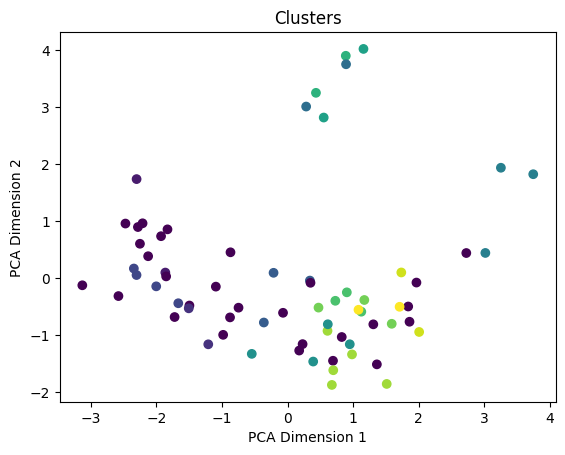

In [107]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Perform PCA dimensionality reduction
pca = PCA(n_components=2)  # or 3 for 3D
embeddings_pca = pca.fit_transform(embeddings)

# Plot the clusters
if pca.n_components == 2:
    plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], c=clusters)
    plt.xlabel("PCA Dimension 1")
    plt.ylabel("PCA Dimension 2")
else:
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], embeddings_pca[:, 2], c=clusters)
    ax.set_xlabel("PCA Dimension 1")
    ax.set_ylabel("PCA Dimension 2")
    ax.set_zlabel("PCA Dimension 3")
plt.title("Clusters")
plt.show()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


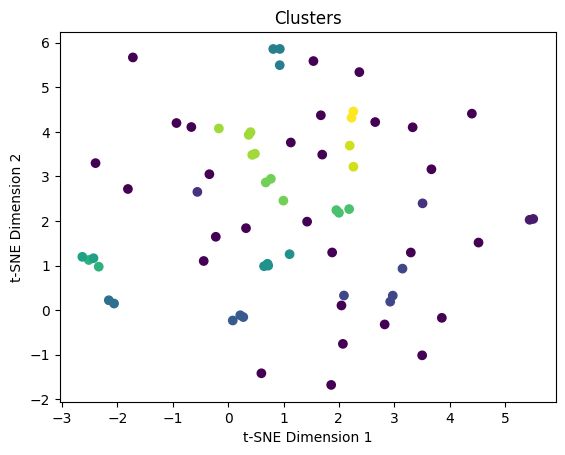

In [108]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

# Plot the clusters
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=clusters)
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.title("Clusters")
plt.show()

In [ ]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})

def generateClusterName(descriptions):
    txt = "Summarize the following diseases into a common disease name:"
    for description in descriptions:
        txt += f" - {description}\n"
    inputs = tokenizer.encode(
        txt, 
        return_tensors="pt", 
        padding=True,
        max_length=1024,
        truncation=True,
        add_special_tokens=True
        )
    outputs = model.generate(
        inputs, 
        # attention_mask=inputs['attention_mask'],
        max_length=500, 
        num_return_sequences=1, 
        no_repeat_ngram_size=2,
        pad_token_id=tokenizer.eos_token_id
        )
    generated = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return generated.split('\n')[0].strip()

cluster_names= {}

for cluster, description in clustered_indications.items():
    print(cluster)
    if cluster != -1:
        cluster_names[cluster] = generateClusterName(description)
        print(f"Cluster {cluster}:")
        print(f"Cluster name:" + cluster_names[cluster])
        for desc in description:
            print(f"  - {desc}")

# for cluster, description in clustered_indications.items():
#     if cluster == -1:
#         continue
#     print(f"Cluster {cluster}: {cluster_names[cluster]}")
#     for desc in description:
#         print(f"  - {desc}")

In [ ]:
tqdm.pandas()

save_directory = '/Users/jada/Desktop/Project/unbIAsed.Rx/CSVFiles'

# function to apply as chunks
def process_and_save_chunk(df_chunk, chunk_index):
    # Apply the get_alternate_drug function
    df_chunk["Alternate drugname"] = df_chunk["DRUGNAME"].progress_apply(get_alternate_drug)
    # Create the file path for saving the CSV
    csv_file_path = os.path.join(save_directory, f"altdrug_chunk_{chunk_index}.csv")
    # Save the DataFrame chunk to a CSV file
    df_chunk.to_csv(csv_file_path, index=False)
    # Optionally print the chunk
    print(f"Chunk {chunk_index} processed and saved.")
    print(df_chunk.head())  # Print only the first few rows to avoid clutter

# Define the chunk size
chunk_size = 250
starting_chunk_index = 0
# Split the DataFrame into chunks and process each chunk
for chunk_index, start_row in enumerate(range(0, drugname_df.shape[0], chunk_size), start=starting_chunk_index):
    # Get the current chunk
    df_chunk = drugname_df.iloc[start_row:start_row + chunk_size]
    # Process and save the current chunk
    process_and_save_chunk(df_chunk, chunk_index)

In [ ]:
# concatenate all chunks together into a single csv file
save_directory = '/Users/jada/Desktop/Project/unbIAsed.Rx/CSVFiles'
output_file = os.path.join(save_directory, 'AlternateDrugs.csv')

# List to store DataFrames
df_list = []

# Iterate over all files in the save directory
for filename in sorted(os.listdir(save_directory)):
    if filename.startswith('altdrug_chunk_') and filename.endswith('.csv'):
        file_path = os.path.join(save_directory, filename)
        # Read the CSV file into a DataFrame
        df_chunk = pd.read_csv(file_path)
        # Append the DataFrame to the list
        df_list.append(df_chunk)
        print(f"Processed {filename}")

# Concatenate all DataFrames in the list
combined_df = pd.concat(df_list, ignore_index=True)

# Save the combined DataFrame to a single CSV file
combined_df.to_csv(output_file, index=False)